In [1]:
import os
import shutil
import tensorflow as tf
from google.colab import drive
import xml.etree.ElementTree as ET # For parsing XML annotations
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("Installing KerasCV and other required libraries...")

# Install KerasCV and Keras (often good to explicitly install Keras too)
!pip install -q keras-cv keras

# Install lxml for robust XML parsing if not already present
!pip install -q lxml

print("Installation complete!")

# Verify TensorFlow and Keras versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Mount Google Drive again (if you restarted runtime, which you should have)
print("\nMounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# Define paths (re-confirm these are correct from your previous successful unzip)
zip_file_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip'
unzip_destination_path = '/content/drive/My Drive/galapagos_seals_annotated_data/'

# Check if data is already unzipped, if not, unzip it

if not os.path.exists(os.path.join(unzip_destination_path, 'my_galapagos_seals_dataset')):
    print(f"Data not found at {unzip_destination_path}. Unzipping {zip_file_path}...")
    if not os.path.exists(unzip_destination_path):
        os.makedirs(unzip_destination_path)
    try:
        shutil.unpack_archive(zip_file_path, unzip_destination_path)
        print("Unzipping complete!")
    except Exception as e:
        print(f"Error unzipping file: {e}")
        print("Please ensure the 'zip_file_path' is correct and the file exists.")
else:
    print(f"Data already unzipped at {unzip_destination_path}. Skipping unzip.")

# Set the base path for your unzipped dataset for future use
DATASET_BASE_PATH = os.path.join(unzip_destination_path, 'my_galapagos_seals_dataset')
print(f"\nYour dataset is now accessible at: {DATASET_BASE_PATH}")

Installing KerasCV and other required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.2 MB/s eta 0:00:00
Installation complete!
TensorFlow version: 2.18.0
Keras version: 3.8.0

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!
Data already unzipped at /content/drive/My Drive/galapagos_seals_annotated_data/. Skipping unzip.

Your dataset is now accessible at: /content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset


Class to ID mapping: {'Arctocephalus_galapagoensis': 0, 'Zalophus_wollebaeki': 1}

Loading dataset paths and annotations...
Train samples: 266
Validation samples: 34
Test samples: 34

Displaying a sample training image with annotations...


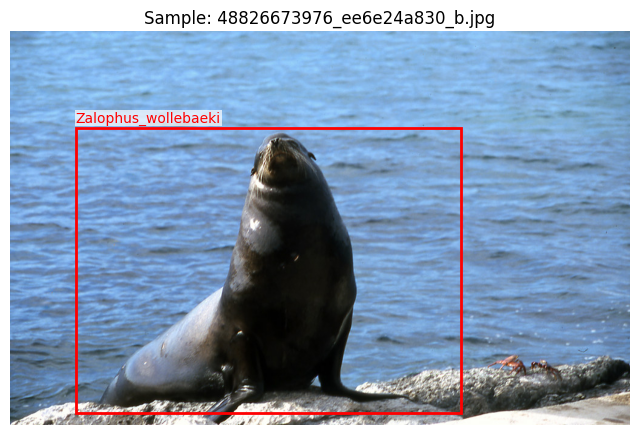

In [2]:
# Define your class names in the order they appear in classes.txt (and how you annotated them)
# This order will determine their integer IDs (0, 1, etc.)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]

# Create a mapping from class name to integer ID
CLASS_TO_ID = {name: i for i, name in enumerate(CLASS_NAMES)}
ID_TO_CLASS = {i: name for i, name in enumerate(CLASS_NAMES)}

print(f"Class to ID mapping: {CLASS_TO_ID}")

def parse_voc_annotation(image_path, annotations_dir):
    """
    Parses a single Pascal VOC XML annotation file and returns bounding box
    information.

    Args:
        image_path (str): Full path to the image file.
        annotations_dir (str): Path to the directory containing XML annotations.

    Returns:
        dict: A dictionary containing 'boxes' (np.array) and 'classes' (np.array).
              Boxes are in [y_min, x_min, y_max, x_max] format.
              Returns None if the annotation file is not found.
    """
    image_filename = os.path.basename(image_path)
    annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
    annotation_filepath = os.path.join(annotations_dir, annotation_filename)

    if not os.path.exists(annotation_filepath):
        # print(f"Warning: Annotation file not found for {image_filename} at {annotation_filepath}")
        return None # Or return an empty dictionary for images with no annotations

    tree = ET.parse(annotation_filepath)
    root = tree.getroot()

    boxes = []
    classes = []

    # Get image dimensions from XML (important for validation and potential normalization later)
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)

    for obj in root.iter('object'):
        label = obj.find('name').text
        if label not in CLASS_TO_ID:
            print(f"Warning: Unknown label '{label}' found in {annotation_filepath}. Skipping.")
            continue

        class_id = CLASS_TO_ID[label]
        xml_box = obj.find('bndbox')
        xmin = float(xml_box.find('xmin').text)
        ymin = float(xml_box.find('ymin').text)
        xmax = float(xml_box.find('xmax').text)
        ymax = float(xml_box.find('ymax').text)

        # Convert to [y_min, x_min, y_max, x_max] format for KerasCV
        boxes.append([ymin, xmin, ymax, xmax])
        classes.append(class_id)

    return {
        "boxes": np.array(boxes, dtype=np.float32),
        "classes": np.array(classes, dtype=np.float32), # KerasCV expects float
        "image_width": img_width,
        "image_height": img_height
    }

def load_dataset_paths_and_annotations(dataset_base_path, class_names):
    """
    Loads all image paths and their corresponding parsed annotations from the dataset.
    Separates into train, validation, and test sets.
    """
    train_image_paths = []
    val_image_paths = []
    test_image_paths = []

    train_annotations = []
    val_annotations = []
    test_annotations = []

    annotations_dir = os.path.join(dataset_base_path, 'Annotations')

    for split in ['train', 'validation', 'test']:
        split_dir = os.path.join(dataset_base_path, split)
        current_image_paths = []
        current_annotations_list = []

        for class_name in class_names:
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory not found: {class_dir}. Skipping.")
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    image_path = os.path.join(class_dir, img_name)
                    annotation_data = parse_voc_annotation(image_path, annotations_dir)

                    if annotation_data is not None and len(annotation_data['boxes']) > 0:
                        current_image_paths.append(image_path)
                        current_annotations_list.append(annotation_data)
                    # else:
                        # print(f"Skipping image {img_name}: No valid annotations found or annotation file missing.")

        # Assign to appropriate list
        if split == 'train':
            train_image_paths.extend(current_image_paths)
            train_annotations.extend(current_annotations_list)
        elif split == 'validation':
            val_image_paths.extend(current_image_paths)
            val_annotations.extend(current_annotations_list)
        elif split == 'test':
            test_image_paths.extend(current_image_paths)
            test_annotations.extend(current_annotations_list)

    return (train_image_paths, train_annotations,
            val_image_paths, val_annotations,
            test_image_paths, test_annotations)


print("\nLoading dataset paths and annotations...")
train_image_paths, train_annotations, \
val_image_paths, val_annotations, \
test_image_paths, test_annotations = load_dataset_paths_and_annotations(DATASET_BASE_PATH, CLASS_NAMES)

print(f"Train samples: {len(train_image_paths)}")
print(f"Validation samples: {len(val_image_paths)}")
print(f"Test samples: {len(test_image_paths)}")

# Optional: Display a sample image with its bounding boxes to verify parsing
if train_image_paths:
    print("\nDisplaying a sample training image with annotations...")
    sample_index = random.randint(0, len(train_image_paths) - 1)
    sample_image_path = train_image_paths[sample_index]
    sample_annotation = train_annotations[sample_index]

    # Load image using tf.keras.utils.load_img
    img = tf.keras.utils.load_img(sample_image_path)
    img_array = tf.keras.utils.img_to_array(img)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img_array.astype(np.uint8))

    for i, box in enumerate(sample_annotation['boxes']):
        ymin, xmin, ymax, xmax = box
        class_id = int(sample_annotation['classes'][i])
        class_name = ID_TO_CLASS[class_id]

        # KerasCV boxes are ymin, xmin, ymax, xmax. Matplotlib patches use (xmin, ymin) for origin.
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, class_name, color='red', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

    ax.axis('off')
    plt.title(f"Sample: {os.path.basename(sample_image_path)}")
    plt.show()
else:
    print("No training images found to display a sample.")

In [3]:
import os
import shutil
from google.colab import drive
import xml.etree.ElementTree as ET # For parsing XML annotations
import random
from PIL import Image # To get image dimensions

print("Installing Ultralytics YOLOv8...")
!pip install -q ultralytics # -q for quiet installation
print("Ultralytics YOLOv8 installed successfully!")

# Verify installation (optional)
try:
    from ultralytics import YOLO
    print(f"YOLOv8 imported successfully from ultralytics version {YOLO.__version__}")
except ImportError:
    print("Failed to import YOLOv8. There might be an issue with the installation.")

# Remount Google Drive and verify data path (essential step after potential restarts)
print("\nMounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# Define paths (re-confirm these are correct from your previous successful unzip)
zip_file_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip'
unzip_destination_path = '/content/drive/My Drive/galapagos_seals_annotated_data/'

# Check if data is already unzipped, if not, unzip it
if not os.path.exists(os.path.join(unzip_destination_path, 'my_galapagos_seals_dataset')):
    print(f"Data not found at {unzip_destination_path}. Unzipping {zip_file_path}...")
    if not os.path.exists(unzip_destination_path):
        os.makedirs(unzip_destination_path)
    try:
        shutil.unpack_archive(zip_file_path, unzip_destination_path)
        print("Unzipping complete!")
    except Exception as e:
        print(f"Error unzipping file: {e}")
        print("Please ensure the 'zip_file_path' is correct and the file exists.")
else:
    print(f"Data already unzipped at {unzip_destination_path}. Skipping unzip.")

# Set the base path for your unzipped dataset for future use
DATASET_BASE_PATH = os.path.join(unzip_destination_path, 'my_galapagos_seals_dataset')
print(f"\nYour dataset is now accessible at: {DATASET_BASE_PATH}")

Installing Ultralytics YOLOv8...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
Ultralytics YOLOv8 installed successfully!
Creating new Ultralytics Settings v0.0.6 file ✅ 
Vi

AttributeError: type object 'YOLO' has no attribute '__version__'

In [4]:
import os
import xml.etree.ElementTree as ET
from PIL import Image # Used to get image dimensions
import shutil # For creating directories and moving files
import random # For shuffling and sample display

# Re-define CLASS_NAMES (must match your dataset's classes.txt order)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASS_NAMES)}

print(f"Using {len(CLASS_NAMES)} classes for YOLOv8: {CLASS_NAMES}")

# Define base path for your unzipped dataset (from previous cells)
# DATASET_BASE_PATH = '/content/galapagos_seals_annotated_data/my_galapagos_seals_dataset' # Ensure this is correct

# Define the root directory for the new YOLO-formatted dataset
YOLO_DATA_ROOT = os.path.join('/content/drive/My Drive', 'yolov8_data')

# --- IMPORTANT: Clean up previous YOLO_DATA_ROOT to ensure a fresh start ---
if os.path.exists(YOLO_DATA_ROOT):
    print(f"Cleaning up existing YOLO_DATA_ROOT: {YOLO_DATA_ROOT}")
    shutil.rmtree(YOLO_DATA_ROOT)
    print("Clean up complete.")

# Create necessary directories for YOLOv8 format
# images/train, images/val, images/test
# labels/train, labels/val, labels/test
for split_folder in ['train', 'val', 'test']: # Use 'val' for validation
    os.makedirs(os.path.join(YOLO_DATA_ROOT, 'images', split_folder), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DATA_ROOT, 'labels', split_folder), exist_ok=True)

print(f"\nCreated fresh YOLOv8 data structure at: {YOLO_DATA_ROOT}")

def convert_bbox_voc_to_yolo(size, box):
    """
    Converts Pascal VOC [xmin, ymin, xmax, ymax] to YOLO [center_x, center_y, width, height]
    and normalizes coordinates.

    Args:
        size (tuple): (width, height) of the image.
        box (list): [xmin, ymin, xmax, ymax] from Pascal VOC.

    Returns:
        tuple: (center_x, center_y, width, height) in normalized YOLO format.
    """
    img_width, img_height = size
    xmin, ymin, xmax, ymax = box

    # Calculate center, width, height
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0
    width = xmax - xmin
    height = ymax - ymin

    # Normalize
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return (center_x, center_y, width, height)

def process_pascal_voc_dataset(dataset_base_path, yolo_data_root, class_to_id_map):
    """
    Processes the Pascal VOC dataset, converts annotations, and organizes files
    into YOLOv8 format.
    """
    annotations_dir = os.path.join(dataset_base_path, 'Annotations')

    # Define the mapping from your original split names to YOLOv8's expected names
    split_map = {
        'train': 'train',
        'validation': 'val', # Correctly map 'validation' to 'val'
        'test': 'test'
    }

    for original_split_name, yolo_split_name in split_map.items():
        voc_split_dir = os.path.join(dataset_base_path, original_split_name)
        yolo_images_split_dir = os.path.join(yolo_data_root, 'images', yolo_split_name)
        yolo_labels_split_dir = os.path.join(yolo_data_root, 'labels', yolo_split_name)

        print(f"\nProcessing '{original_split_name}' split (mapping to YOLO '{yolo_split_name}')...")

        # Get all image paths for this split
        image_paths = []
        # Iterate through your known classes' subfolders within the split
        for class_name_folder in os.listdir(voc_split_dir):
            class_folder_path = os.path.join(voc_split_dir, class_name_folder)
            if os.path.isdir(class_folder_path): # Ensure it's a directory
                for img_name in os.listdir(class_folder_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(class_folder_path, img_name))
            # else: print(f"  Skipping non-directory item in split: {class_name_folder}")


        # Shuffle paths to mix classes if they are in subfolders
        random.shuffle(image_paths)

        # Process each image and its annotation
        processed_count = 0
        for image_path in image_paths:
            img_filename = os.path.basename(image_path)
            annotation_filename = os.path.splitext(img_filename)[0] + '.xml'
            annotation_filepath = os.path.join(annotations_dir, annotation_filename)

            if not os.path.exists(annotation_filepath):
                # print(f"  Skipping {img_filename}: No annotation file found.")
                continue

            try:
                # Get image dimensions using PIL
                with Image.open(image_path) as img:
                    img_width, img_height = img.size

                tree = ET.parse(annotation_filepath)
                root = tree.getroot()

                yolo_lines = []
                for obj in root.iter('object'):
                    label = obj.find('name').text
                    if label not in class_to_id_map:
                        print(f"  Warning: Unknown label '{label}' in {annotation_filename}. Skipping object.")
                        continue

                    class_id = class_to_id_map[label]
                    xml_box = obj.find('bndbox')
                    xmin = float(xml_box.find('xmin').text)
                    ymin = float(xml_box.find('ymin').text)
                    xmax = float(xml_box.find('xmax').text)
                    ymax = float(xml_box.find('ymax').text)

                    # Ensure coordinates are valid (e.g., xmax > xmin, etc.)
                    if not (xmin < xmax and ymin < ymax):
                        print(f"  Warning: Invalid bounding box in {annotation_filename} for label '{label}'. Skipping object.")
                        continue

                    # Adjust for potential 1-based indexing in Pascal VOC if necessary.
                    # If xmin/ymin are 1, then subtract 1 for 0-based.
                    # This is generally handled by the float conversion, but explicit check for 0-based
                    # is often safer. For simplicity, we'll assume they are already 0-based or handled by float.
                    # If you encounter issues later, check if xmin/ymin should be x-1, y-1.

                    bbox_yolo = convert_bbox_voc_to_yolo((img_width, img_height), [xmin, ymin, xmax, ymax])
                    yolo_lines.append(f"{class_id} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}")

                if yolo_lines: # Only proceed if there are valid bounding boxes
                    # Save YOLO annotation file
                    yolo_label_filepath = os.path.join(yolo_labels_split_dir, os.path.splitext(img_filename)[0] + '.txt')
                    with open(yolo_label_filepath, 'w') as f:
                        f.write('\n'.join(yolo_lines))

                    # Copy image to YOLO image directory
                    shutil.copy(image_path, os.path.join(yolo_images_split_dir, img_filename))
                    processed_count += 1
                # else:
                    # print(f"  Skipping {img_filename}: No valid objects with known labels found.")

            except Exception as e:
                print(f"  Error processing {img_filename} (annotation {annotation_filename}): {e}")

        print(f"Processed {processed_count} images for '{original_split_name}' split into YOLOv8 '{yolo_split_name}' format.")

# Run the conversion
process_pascal_voc_dataset(DATASET_BASE_PATH, YOLO_DATA_ROOT, CLASS_TO_ID)

# Optional: Verify the conversion by listing some files
print("\nVerifying converted files:")
print(f"Train images: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'images', 'train')))}")
print(f"Train labels: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'labels', 'train')))}")
print(f"Val images: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'images', 'val')))}")
print(f"Val labels: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'labels', 'val')))}")
print(f"Test images: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'images', 'test')))}")
print(f"Test labels: {len(os.listdir(os.path.join(YOLO_DATA_ROOT, 'labels', 'test')))}")

# Show a sample YOLO label file (optional)
sample_label_dir = os.path.join(YOLO_DATA_ROOT, 'labels', 'train')
if os.path.exists(sample_label_dir) and os.listdir(sample_label_dir):
    sample_label_file = random.choice(os.listdir(sample_label_dir))
    print(f"\nSample YOLO label file ({sample_label_file}):")
    with open(os.path.join(sample_label_dir, sample_label_file), 'r') as f:
        print(f.read())

Using 2 classes for YOLOv8: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Cleaning up existing YOLO_DATA_ROOT: /content/drive/My Drive/yolov8_data
Clean up complete.

Created fresh YOLOv8 data structure at: /content/drive/My Drive/yolov8_data

Processing 'train' split (mapping to YOLO 'train')...
Processed 266 images for 'train' split into YOLOv8 'train' format.

Processing 'validation' split (mapping to YOLO 'val')...
Processed 34 images for 'validation' split into YOLOv8 'val' format.

Processing 'test' split (mapping to YOLO 'test')...
Processed 34 images for 'test' split into YOLOv8 'test' format.

Verifying converted files:
Train images: 266
Train labels: 266
Val images: 34
Val labels: 34
Test images: 34
Test labels: 34

Sample YOLO label file (32680757.txt):
1 0.491500 0.504505 0.527000 0.735736


In [ ]:
from ultralytics import YOLO
import os

# Define the path to your data.yaml file, which is on Drive
# This path should be correct from our previous successful run
YOLO_DATA_ROOT_ON_DRIVE = os.path.join('/content/drive/My Drive', 'yolov8_data')
DATA_YAML_PATH = os.path.join(YOLO_DATA_ROOT_ON_DRIVE, 'seals_dataset.yaml')

# Choose a pre-trained YOLOv8 model
MODEL_NAME = 'yolov8n.pt'

# Load a pre-trained YOLOv8 model
model = YOLO(MODEL_NAME)

print(f"Loaded YOLOv8 model: {MODEL_NAME}")

# --- IMPORTANT CHANGE HERE: project now points to Google Drive ---
PROJECT_DIR_ON_DRIVE = os.path.join('/content/drive/My Drive', 'yolov8_training_results') # Create a new folder for results on Drive
# Ensure this directory exists before training if it doesn't already
os.makedirs(PROJECT_DIR_ON_DRIVE, exist_ok=True)


# Define training parameters
EPOCHS = 50       # Number of training epochs (you can increase this later)
IMG_SIZE = 640    # Image size for training
BATCH_SIZE = 16   # Batch size (adjust based on GPU memory)
# Name for this specific training run, will be a subfolder inside PROJECT_DIR_ON_DRIVE
RUN_NAME = 'yolov8n_finetune_persistent'

print("\nStarting YOLOv8 training (results will save to Google Drive)...")
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=RUN_NAME,
    project=PROJECT_DIR_ON_DRIVE, # <-- This is the key change!
    cache=True
)

print("\nTraining complete! Results saved to Google Drive.")
print(f"You can find your results, including weights, plots, and logs, in:")
print(f"{PROJECT_DIR_ON_DRIVE}/{RUN_NAME}/")
# Specifically, the best weights will be at:
# {PROJECT_DIR_ON_DRIVE}/{RUN_NAME}/weights/best.pt

Loaded YOLOv8 model: yolov8n.pt

Starting YOLOv8 training (results will save to Google Drive)...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/yolov8_data/seals_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_finetune_persistent2, nbs=6

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751702  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 11.6±24.0 ms, read: 0.7±0.7 MB/s, size: 234.4 KB)


train: Scanning /content/drive/My Drive/yolov8_data/labels/train.cache... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 266/266 [00:03<00:00, 79.31it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 1.0±0.5 MB/s, size: 210.4 KB)


val: Scanning /content/drive/My Drive/yolov8_data/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 34/34 [00:04<00:00,  6.91it/s]

Plotting labels to /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.501      2.686      1.647         31        640: 100%|██████████| 17/17 [03:43<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]

                   all         34         64          1     0.0322      0.354      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.427      2.014      1.513         26        640: 100%|██████████| 17/17 [03:29<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]

                   all         34         64      0.889      0.208      0.318      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.432      1.943      1.539         38        640: 100%|██████████| 17/17 [03:26<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]

                   all         34         64      0.777      0.167      0.203     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.439      1.898       1.52         45        640: 100%|██████████| 17/17 [03:29<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]

                   all         34         64      0.345      0.192      0.248      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.534      1.967       1.61         39        640: 100%|██████████| 17/17 [03:26<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]

                   all         34         64       0.41      0.392      0.367      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.485      1.844      1.603         47        640: 100%|██████████| 17/17 [03:27<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]

                   all         34         64      0.317        0.2      0.249      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.528      1.811      1.604         28        640: 100%|██████████| 17/17 [03:32<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]

                   all         34         64      0.683       0.35      0.393      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.494      1.715      1.608         29        640: 100%|██████████| 17/17 [03:29<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]

                   all         34         64      0.415      0.617      0.476      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.513      1.706       1.59         18        640: 100%|██████████| 17/17 [03:26<00:00, 12.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]

                   all         34         64       0.63      0.475      0.502      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.486      1.658      1.566         30        640: 100%|██████████| 17/17 [03:31<00:00, 12.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.78s/it]

                   all         34         64      0.862      0.457      0.539      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.405      1.549      1.538         20        640: 100%|██████████| 17/17 [03:26<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

                   all         34         64      0.742      0.493      0.616      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.458      1.529      1.547         28        640: 100%|██████████| 17/17 [03:27<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]

                   all         34         64      0.653       0.35      0.533      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.429      1.443      1.502         25        640: 100%|██████████| 17/17 [03:26<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]

                   all         34         64      0.623      0.262      0.454      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.433       1.47      1.501         34        640: 100%|██████████| 17/17 [03:24<00:00, 12.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]

                   all         34         64      0.598      0.342      0.476      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.416      1.425      1.522         33        640: 100%|██████████| 17/17 [03:24<00:00, 12.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]

                   all         34         64      0.518      0.658      0.579      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.422      1.436       1.53         33        640: 100%|██████████| 17/17 [03:25<00:00, 12.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.67s/it]

                   all         34         64      0.452        0.7      0.547      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.321      1.313      1.437         33        640: 100%|██████████| 17/17 [03:24<00:00, 12.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]

                   all         34         64      0.796      0.722      0.731      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.354      1.357      1.497         25        640: 100%|██████████| 17/17 [03:26<00:00, 12.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.73s/it]

                   all         34         64      0.772      0.392      0.591      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.376      1.281      1.472         29        640: 100%|██████████| 17/17 [03:27<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]

                   all         34         64      0.677      0.519      0.601      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.314      1.266      1.436         34        640: 100%|██████████| 17/17 [03:25<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.71s/it]

                   all         34         64      0.645      0.434      0.556      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.303      1.263      1.431         23        640: 100%|██████████| 17/17 [03:24<00:00, 12.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]

                   all         34         64       0.86      0.508      0.565      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.252      1.221       1.39         31        640: 100%|██████████| 17/17 [03:27<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]

                   all         34         64      0.872      0.508      0.632      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.231      1.119      1.374         33        640: 100%|██████████| 17/17 [03:25<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]

                   all         34         64      0.666      0.525      0.611      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.228      1.132       1.36         24        640: 100%|██████████| 17/17 [03:26<00:00, 12.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

                   all         34         64      0.589      0.517      0.595      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.199      1.102      1.345         34        640: 100%|██████████| 17/17 [03:26<00:00, 12.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]

                   all         34         64      0.617       0.61      0.578      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.228      1.157      1.382         42        640: 100%|██████████| 17/17 [03:27<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

                   all         34         64      0.881      0.567      0.629      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.225      1.106      1.362         38        640: 100%|██████████| 17/17 [03:28<00:00, 12.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]

                   all         34         64      0.634      0.527      0.652      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.151      1.013      1.309         29        640: 100%|██████████| 17/17 [03:28<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.33s/it]

                   all         34         64      0.502      0.717      0.676      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.17      1.028      1.343         31        640: 100%|██████████| 17/17 [03:28<00:00, 12.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.93s/it]

                   all         34         64      0.677      0.654      0.697      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.094     0.9511      1.277         39        640: 100%|██████████| 17/17 [03:24<00:00, 12.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.82s/it]

                   all         34         64      0.739      0.633      0.705      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G       1.11      1.016      1.317         29        640: 100%|██████████| 17/17 [03:27<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]

                   all         34         64      0.675      0.658      0.686      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.093     0.9384      1.298         33        640: 100%|██████████| 17/17 [03:28<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

                   all         34         64      0.689      0.641      0.691      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.057      0.964      1.275         19        640: 100%|██████████| 17/17 [03:31<00:00, 12.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]

                   all         34         64      0.554      0.533      0.641      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.099     0.9368      1.272         30        640: 100%|██████████| 17/17 [03:27<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]

                   all         34         64       0.51      0.717       0.66      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.082     0.9064      1.268         51        640: 100%|██████████| 17/17 [03:29<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]

                   all         34         64      0.624      0.533      0.655      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.069     0.9083       1.27         33        640: 100%|██████████| 17/17 [03:29<00:00, 12.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.86s/it]

                   all         34         64       0.69       0.53      0.667      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.018     0.8492      1.239         44        640: 100%|██████████| 17/17 [03:28<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]

                   all         34         64      0.668      0.576      0.679      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.019     0.8622      1.231         28        640: 100%|██████████| 17/17 [03:30<00:00, 12.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]

                   all         34         64      0.755      0.725      0.719      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9915     0.8427      1.226         45        640: 100%|██████████| 17/17 [03:28<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

                   all         34         64       0.74      0.715      0.719      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      0.982     0.8151      1.229         37        640: 100%|██████████| 17/17 [03:28<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]

                   all         34         64      0.709      0.723      0.699      0.449


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9163     0.8842      1.238         13        640: 100%|██████████| 17/17 [03:28<00:00, 12.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.81s/it]

                   all         34         64      0.729       0.68      0.638      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9366     0.8163      1.223         17        640: 100%|██████████| 17/17 [03:29<00:00, 12.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

                   all         34         64      0.735       0.68      0.641      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9007     0.7128      1.196         12        640: 100%|██████████| 17/17 [03:24<00:00, 12.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.53s/it]

                   all         34         64      0.914      0.717      0.749      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.8256     0.6812      1.151         15        640: 100%|██████████| 17/17 [03:21<00:00, 11.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

                   all         34         64      0.899      0.704      0.757      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8377     0.6553      1.132         11        640: 100%|██████████| 17/17 [03:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.85s/it]

                   all         34         64      0.834      0.702      0.767      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8265     0.6454       1.12         14        640: 100%|██████████| 17/17 [03:22<00:00, 11.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]

                   all         34         64      0.839        0.7      0.774      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.7807     0.6357      1.109         11        640: 100%|██████████| 17/17 [03:23<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.86s/it]

                   all         34         64      0.918      0.673      0.781      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7798      0.624      1.117         24        640: 100%|██████████| 17/17 [03:25<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]

                   all         34         64      0.755      0.709      0.742      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.7461     0.6116      1.067         16        640: 100%|██████████| 17/17 [03:21<00:00, 11.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]

                   all         34         64      0.718      0.708      0.732      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.7664     0.5952      1.099         13        640: 100%|██████████| 17/17 [03:23<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]

                   all         34         64      0.719      0.708      0.742      0.473



50 epochs completed in 2.990 hours.
Optimizer stripped from /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2/weights/best.pt, 6.2MB

Validating /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


                   all         34         64      0.898      0.705      0.757      0.486
Arctocephalus_galapagoensis          4          4      0.928       0.75      0.753      0.577
   Zalophus_wollebaeki         30         60      0.868      0.659      0.762      0.395
Speed: 2.0ms preprocess, 182.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent2

Training complete! Results saved to Google Drive.
You can find your results, including weights, plots, and logs, in:
/content/drive/My Drive/yolov8_training_results/yolov8n_finetune_persistent/


In [5]:
import os

# Define the path for the data.yaml file
DATA_YAML_PATH = os.path.join('/content/drive/My Drive/yolov8_data', 'seals_dataset.yaml')

# Define the content of the data.yaml file
# 'train' and 'val' paths are relative to the location of this YAML file
data_yaml_content = f"""
path: {os.path.abspath('/content/drive/My Drive/yolov8_data')}
train: images/train
val: images/val
test: images/test

# number of classes
nc: {len(CLASS_NAMES)}

# class names
names: {CLASS_NAMES}
"""

# Write the content to the .yaml file
with open(DATA_YAML_PATH, 'w') as f:
    f.write(data_yaml_content)

print(f"YOLOv8 data configuration file created at: {DATA_YAML_PATH}")
print("\nContent of seals_dataset.yaml:")
print(data_yaml_content)

YOLOv8 data configuration file created at: /content/drive/My Drive/yolov8_data/seals_dataset.yaml

Content of seals_dataset.yaml:

path: /content/drive/My Drive/yolov8_data
train: images/train
val: images/val
test: images/test

# number of classes
nc: 2

# class names
names: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']



In [6]:
from ultralytics import YOLO
import os

# Define the path to your data.yaml file
DATA_YAML_PATH = os.path.join('/content/drive/My Drive/yolov8_data', 'seals_dataset.yaml')

# Choose a pre-trained YOLOv8 model
# Options: 'yolov8n.pt' (nano, fastest/smallest), 'yolov8s.pt' (small), 'yolov8m.pt' (medium), etc.
# Start with 'yolov8n.pt' for faster training and to ensure everything works.
MODEL_NAME = 'yolov8n.pt'

# Load a pre-trained YOLOv8 model
model = YOLO(MODEL_NAME)

print(f"Loaded YOLOv8 model: {MODEL_NAME}")

# Define training parameters
# You can adjust these based on your needs and computational resources
EPOCHS = 50       # Number of training epochs
IMG_SIZE = 640    # Image size for training (YOLOv8 default is 640)
BATCH_SIZE = 16   # Batch size (adjust based on GPU memory; smaller if OOM)
PROJECT_NAME = 'galapagos_seals_detection' # Name of the project
RUN_NAME = 'yolov8n_finetune' # Name for this specific training run

print("\nStarting YOLOv8 training...")
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=RUN_NAME,
    project=PROJECT_NAME,
    cache=True # Cache images to RAM/disk for faster training
)

print("\nTraining complete! Results saved to disk.")

# Training results (metrics, weights) are saved in:
# /content/runs/detect/PROJECT_NAME/RUN_NAME/
# e.g., /content/runs/detect/galapagos_seals_detection/yolov8n_finetune/

100%|██████████| 6.25M/6.25M [00:00<00:00, 58.9MB/s]


Loaded YOLOv8 model: yolov8n.pt

Starting YOLOv8 training...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/yolov8_data/seals_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_finetune, nbs=64, nms=False, opset=None, optimize=False, optimi

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751702  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.7±0.6 ms, read: 53.2±34.8 MB/s, size: 234.4 KB)


train: Scanning /content/drive/My Drive/yolov8_data/labels/train... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:02<00:00, 95.36it/s] 


train: New cache created: /content/drive/My Drive/yolov8_data/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 266/266 [00:04<00:00, 62.45it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 79.1±33.7 MB/s, size: 210.4 KB)


val: Scanning /content/drive/My Drive/yolov8_data/labels/val... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 108.20it/s]

val: New cache created: /content/drive/My Drive/yolov8_data/labels/val.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 34/34 [00:00<00:00, 72.69it/s]

Plotting labels to galapagos_seals_detection/yolov8n_finetune/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to galapagos_seals_detection/yolov8n_finetune
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.501      2.686      1.647         31        640: 100%|██████████| 17/17 [04:05<00:00, 14.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.89s/it]

                   all         34         64          1     0.0322      0.354      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.427      2.014      1.513         26        640: 100%|██████████| 17/17 [03:50<00:00, 13.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]

                   all         34         64      0.889      0.208      0.318      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.432      1.943      1.539         38        640: 100%|██████████| 17/17 [03:50<00:00, 13.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]

                   all         34         64      0.777      0.167      0.203     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.439      1.898       1.52         45        640: 100%|██████████| 17/17 [03:51<00:00, 13.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]

                   all         34         64      0.345      0.192      0.248      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.534      1.967       1.61         39        640: 100%|██████████| 17/17 [03:55<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]

                   all         34         64       0.41      0.392      0.367      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.485      1.844      1.603         47        640: 100%|██████████| 17/17 [03:47<00:00, 13.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]

                   all         34         64      0.317        0.2      0.249      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.528      1.811      1.604         28        640: 100%|██████████| 17/17 [03:49<00:00, 13.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]

                   all         34         64      0.683       0.35      0.393      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.494      1.715      1.608         29        640: 100%|██████████| 17/17 [03:48<00:00, 13.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]

                   all         34         64      0.415      0.617      0.476      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.513      1.706       1.59         18        640: 100%|██████████| 17/17 [03:46<00:00, 13.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]

                   all         34         64       0.63      0.475      0.502      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.486      1.658      1.566         30        640: 100%|██████████| 17/17 [03:52<00:00, 13.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]

                   all         34         64      0.862      0.457      0.539      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.405      1.549      1.538         20        640: 100%|██████████| 17/17 [03:51<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.41s/it]

                   all         34         64      0.742      0.493      0.616      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.458      1.529      1.547         28        640: 100%|██████████| 17/17 [03:47<00:00, 13.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.65s/it]

                   all         34         64      0.653       0.35      0.533      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.429      1.443      1.502         25        640: 100%|██████████| 17/17 [03:54<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]

                   all         34         64      0.623      0.262      0.454      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.433       1.47      1.501         34        640: 100%|██████████| 17/17 [03:50<00:00, 13.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.34s/it]

                   all         34         64      0.598      0.342      0.476      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.416      1.425      1.522         33        640: 100%|██████████| 17/17 [03:46<00:00, 13.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]

                   all         34         64      0.518      0.658      0.579      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.422      1.436       1.53         33        640: 100%|██████████| 17/17 [03:49<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]

                   all         34         64      0.452        0.7      0.547      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.321      1.313      1.437         33        640: 100%|██████████| 17/17 [03:47<00:00, 13.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.88s/it]

                   all         34         64      0.796      0.722      0.731      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.354      1.357      1.497         25        640: 100%|██████████| 17/17 [03:48<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]

                   all         34         64      0.772      0.392      0.591      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.376      1.281      1.472         29        640: 100%|██████████| 17/17 [03:52<00:00, 13.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]

                   all         34         64      0.677      0.519      0.601      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.314      1.266      1.436         34        640: 100%|██████████| 17/17 [03:51<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]

                   all         34         64      0.645      0.434      0.556      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.303      1.263      1.431         23        640: 100%|██████████| 17/17 [03:51<00:00, 13.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]

                   all         34         64       0.86      0.508      0.565      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.252      1.221       1.39         31        640: 100%|██████████| 17/17 [03:47<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]

                   all         34         64      0.872      0.508      0.632      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.231      1.119      1.374         33        640: 100%|██████████| 17/17 [03:52<00:00, 13.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]

                   all         34         64      0.666      0.525      0.611      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.228      1.132       1.36         24        640: 100%|██████████| 17/17 [03:48<00:00, 13.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]

                   all         34         64      0.589      0.517      0.595      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.199      1.102      1.345         34        640: 100%|██████████| 17/17 [03:49<00:00, 13.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]

                   all         34         64      0.617       0.61      0.578      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.228      1.157      1.382         42        640: 100%|██████████| 17/17 [03:47<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]

                   all         34         64      0.881      0.567      0.629      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.225      1.106      1.362         38        640: 100%|██████████| 17/17 [03:48<00:00, 13.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]

                   all         34         64      0.634      0.527      0.652      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.151      1.013      1.309         29        640: 100%|██████████| 17/17 [03:56<00:00, 13.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]

                   all         34         64      0.502      0.717      0.676      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.17      1.028      1.343         31        640: 100%|██████████| 17/17 [03:49<00:00, 13.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]

                   all         34         64      0.677      0.654      0.697      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.094     0.9511      1.277         39        640: 100%|██████████| 17/17 [03:49<00:00, 13.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.80s/it]

                   all         34         64      0.739      0.633      0.705      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G       1.11      1.016      1.317         29        640: 100%|██████████| 17/17 [03:52<00:00, 13.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]

                   all         34         64      0.675      0.658      0.686      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.093     0.9384      1.298         33        640: 100%|██████████| 17/17 [03:50<00:00, 13.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]

                   all         34         64      0.689      0.641      0.691      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.057      0.964      1.275         19        640: 100%|██████████| 17/17 [03:48<00:00, 13.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]

                   all         34         64      0.554      0.533      0.641      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.099     0.9368      1.272         30        640: 100%|██████████| 17/17 [03:53<00:00, 13.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.40s/it]

                   all         34         64       0.51      0.717       0.66      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.082     0.9064      1.268         51        640: 100%|██████████| 17/17 [03:51<00:00, 13.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]

                   all         34         64      0.624      0.533      0.655      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.069     0.9083       1.27         33        640: 100%|██████████| 17/17 [03:55<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]

                   all         34         64       0.69       0.53      0.667      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.018     0.8492      1.239         44        640: 100%|██████████| 17/17 [03:57<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.97s/it]

                   all         34         64      0.668      0.576      0.679      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.019     0.8622      1.231         28        640: 100%|██████████| 17/17 [03:51<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]

                   all         34         64      0.755      0.725      0.719      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9915     0.8427      1.226         45        640: 100%|██████████| 17/17 [03:48<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]

                   all         34         64       0.74      0.715      0.719      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      0.982     0.8151      1.229         37        640: 100%|██████████| 17/17 [03:49<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]

                   all         34         64      0.709      0.723      0.699      0.449


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9163     0.8842      1.238         13        640: 100%|██████████| 17/17 [03:47<00:00, 13.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.65s/it]

                   all         34         64      0.729       0.68      0.638      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9366     0.8163      1.223         17        640: 100%|██████████| 17/17 [03:48<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]

                   all         34         64      0.735       0.68      0.641      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9007     0.7128      1.196         12        640: 100%|██████████| 17/17 [03:48<00:00, 13.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]

                   all         34         64      0.914      0.717      0.749      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.8256     0.6812      1.151         15        640: 100%|██████████| 17/17 [03:49<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]

                   all         34         64      0.899      0.704      0.757      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8377     0.6553      1.132         11        640: 100%|██████████| 17/17 [03:52<00:00, 13.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]

                   all         34         64      0.834      0.702      0.767      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8265     0.6454       1.12         14        640: 100%|██████████| 17/17 [03:49<00:00, 13.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]

                   all         34         64      0.839        0.7      0.774      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.7807     0.6357      1.109         11        640: 100%|██████████| 17/17 [03:46<00:00, 13.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]

                   all         34         64      0.918      0.673      0.781      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7798      0.624      1.117         24        640: 100%|██████████| 17/17 [03:50<00:00, 13.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]

                   all         34         64      0.755      0.709      0.742      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.7461     0.6116      1.067         16        640: 100%|██████████| 17/17 [03:51<00:00, 13.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]

                   all         34         64      0.718      0.708      0.732      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.7664     0.5952      1.099         13        640: 100%|██████████| 17/17 [03:50<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]

                   all         34         64      0.719      0.708      0.742      0.473



50 epochs completed in 3.325 hours.
Optimizer stripped from galapagos_seals_detection/yolov8n_finetune/weights/last.pt, 6.2MB
Optimizer stripped from galapagos_seals_detection/yolov8n_finetune/weights/best.pt, 6.2MB

Validating galapagos_seals_detection/yolov8n_finetune/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


                   all         34         64      0.898      0.705      0.757      0.486
Arctocephalus_galapagoensis          4          4      0.928       0.75      0.753      0.577
   Zalophus_wollebaeki         30         60      0.868      0.659      0.762      0.395
Speed: 2.1ms preprocess, 199.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to galapagos_seals_detection/yolov8n_finetune

Training complete! Results saved to disk.


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Original data not found at /content/galapagos_seals_annotated_data/. Unzipping /content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip...
Error unzipping file: /content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip is not a zip file
Please ensure the 'zip_file_path' is correct and the file exists.

Your original dataset is accessible at: /content/galapagos_seals_annotated_data/my_galapagos_seals_dataset
Your YOLO-formatted dataset is on Drive at: /content/drive/My Drive/yolov8_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Installing Ultralytics YOLOv8...
Ultralytics YOLOv8 installed successfully!


Loaded YOLOv8 model: yolov8n.pt

Starting YOLOv8 training...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/yolov8_data/seals_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_finetune4, nbs=64, nms=False, opset=None, optimize=False, optim

RuntimeError: Dataset '/content/drive/My Drive/yolov8_data/seals_dataset.yaml' error ❌ '/content/drive/My Drive/yolov8_data/seals_dataset.yaml' does not exist